# Solution

Here you will find the solution for the challenge B.

Two traps are needed to reproduce the TDS spectra and the NRA profiles.

The first peak on the TDS correspond to an intrinsic trap (homogeneously distributed) while the second peak correspond to a trap induced by the heavy ion damaged, only present in the first micron.

For this TDS, we used the diffusivity obtained by Frauenfelder but the one from Holzner could be used too.

In [1]:
import festim as F
import sympy as sp
import numpy as np
import h_transport_materials as htm

implantation_time = 2000  # s
temperature_ramp = 4  # K/s
storage_time = 50  # s
storage_temp = 300  # K
start_tds = implantation_time + storage_time  # s

exposure_temps = [300, 400, 500]


def festim_model(T_exp):
    """Runs a festim model and returns the derived quantities

    Args:
        T_exp (float): exposure temperature in K

    Returns:
        F.DerivedQuantities: the derived quantities
    """
    my_model = F.Simulation()

    vertices = np.concatenate(
        [
            np.linspace(0, 30e-9, num=100),
            np.linspace(30e-9, 3e-6, num=200),
            np.linspace(3e-6, 5e-6, num=200),
            np.linspace(5e-6, 20e-6, num=200),
        ]
    )

    my_model.mesh = F.MeshFromVertices(vertices)


    frauenfelder_diff = htm.diffusivities.filter(material=htm.TUNGSTEN, author="frauenfelder")[0]
    tungsten = F.Material(
        id=1,
        D_0=frauenfelder_diff.pre_exp.magnitude,  # m2/s
        E_D=frauenfelder_diff.act_energy.magnitude,  # eV
    )

    my_model.materials = tungsten

    incident_flux = 5e19  # H/m2/s
    reflection_coeff = 0.5
    implanted_flux = incident_flux * (1 - reflection_coeff)
    ion_flux = sp.Piecewise((implanted_flux, F.t <= implantation_time), (0, True))

    source_term = F.ImplantationFlux(
        flux=ion_flux, imp_depth=5e-9, width=2.1e-9, volume=1  # H/m2/s  # m  # m
    )

    my_model.sources = [source_term]

    w_atom_density = 6.3e28  # atom/m3

    trap_1 = F.Trap(
        k_0=tungsten.D_0 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=tungsten.E_D,
        p_0=1e13,
        E_p=0.87,
        density=1e-3 * w_atom_density,
        materials=tungsten,
    )

    trap_2_distrib = sp.Piecewise((1, F.x < 1e-6), (0, True))
    trap_2 = F.Trap(
        k_0=tungsten.D_0 / (1.1e-10**2 * 6 * w_atom_density),
        E_k=tungsten.E_D,
        p_0=1e13,
        E_p=1.2,
        density=4e-4 * w_atom_density * trap_2_distrib,
        materials=tungsten,
    )

    my_model.traps = [trap_1, trap_2]

    my_model.boundary_conditions = [F.DirichletBC(surfaces=[1, 2], value=0, field=0)]

    my_model.T = F.Temperature(
        value=sp.Piecewise(
            (T_exp, F.t <= implantation_time),
            (storage_temp, F.t <= start_tds),
            (storage_temp + temperature_ramp * (F.t - start_tds), True),
        )
    )

    my_model.settings = F.Settings(
        absolute_tolerance=1e10,
        relative_tolerance=1e-10,
        final_time=implantation_time + storage_time + 100,
        traps_element_type="DG",
    )

    list_of_derived_quantities = [
        F.TotalVolume("solute", volume=1),
        F.TotalVolume("retention", volume=1),
        F.TotalVolume("1", volume=1),
        F.TotalVolume("2", volume=1),
        F.AverageVolume("T", volume=1),
        F.HydrogenFlux(surface=1),
        F.HydrogenFlux(surface=2),
    ]

    derived_quantities = F.DerivedQuantities(
        list_of_derived_quantities,
        show_units=True,
        filename=f"{T_exp}_K/derived_quantities.csv",
    )

    txt_exports = [
        F.TXTExport(
            filename=f"{T_exp}_K/retention.txt", field="retention", times=[start_tds]
        ),
        F.TXTExport(filename=f"{T_exp}_K/trap_1.txt", field="1", times=[start_tds]),
        F.TXTExport(filename=f"{T_exp}_K/trap_2.txt", field="2", times=[start_tds]),
    ]

    my_model.exports = [derived_quantities] + txt_exports

    def max_stepsize(t):
        if t >= start_tds:
            return 1
        elif implantation_time <= t <= start_tds:
            return 10
        else:
            return None

    my_model.dt = F.Stepsize(
        initial_value=0.5,
        stepsize_change_ratio=1.1,
        max_stepsize=max_stepsize,
        dt_min=1e-05,
        milestones=[implantation_time, start_tds],
    )

    my_model.initialise()
    my_model.run()
    return derived_quantities

## Results

**Note:** we have to change the filepath here because we are now in a child directory.

In [2]:
import numpy as np
import matplotlib.pyplot as plt


def plot_experimental_tds(T_exp, **kwargs):
    data = np.genfromtxt(
        f"../challenge_B/{T_exp}_K/tds.txt", skip_header=1, delimiter=","
    )
    flux = data[:, -1]
    tds_T = data[:, 1]
    return plt.plot(tds_T, flux, **kwargs)


def plot_nra_profile(T_exp, **kwargs):
    data = np.genfromtxt(
        f"../challenge_B/{T_exp}_K/retention_profile.txt", skip_header=1, delimiter=","
    )
    depth = data[:, 0]
    nra = data[:, 1]
    return plt.step(depth, nra, **kwargs)

def plot_simulated_tds(derived_quantities, **kwargs):
    """Function to plot a simulated TDS spectrum

    Args:
        derived_quantities (festim.DerivedQuantities): the derived quantities object from the simulation.
            Assumes we have an AverageVolume(field="T") and two SurfaceFluxe(fields="solute") for surfaces 1 and 2.
        **kwargs: keyword arguments to be passed to the plot function.
    """
    if derived_quantities == []:

        return
    t = np.array(derived_quantities.t)
    indexes = np.where(t >= start_tds)[0]
    temp = np.array(derived_quantities.filter(fields="T").data)
    flux_left = np.array(derived_quantities.filter(fields="solute", surfaces=1).data)
    flux_right = np.array(derived_quantities.filter(fields="solute", surfaces=2).data)

    flux_total = -flux_left - flux_right

    temp = temp[indexes]
    flux_total = flux_total[indexes]
    t = t[indexes]

    return plt.plot(temp, flux_total, **kwargs)


def plot_simulated_profile(filename: str = "", **kwargs):
    if filename == "":
        return
    data_retention = np.genfromtxt(filename, delimiter=",", skip_header=1)
    return plt.plot(data_retention[:, 0], data_retention[:, 1], **kwargs)

Let's run the model for the three exposure temperatures

In [3]:
T_exp_to_derived_quantities = {}

for T_exp in exposure_temps:
    print("---------------------")
    print(f"Running for {T_exp} K")
    derived_quantities = festim_model(T_exp)
    T_exp_to_derived_quantities[T_exp] = derived_quantities

---------------------
Running for 300 K
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.2e+03 s    Elapsed time so far: 8.2 s
---------------------
Running for 400 K
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.2e+03 s    Elapsed time so far: 5.1 s
---------------------
Running for 500 K
Defining initial values
Defining variational problem
Defining source terms
Defining boundary conditions
Time stepping...
100.0 %        2.2e+03 s    Elapsed time so far: 4.1 s


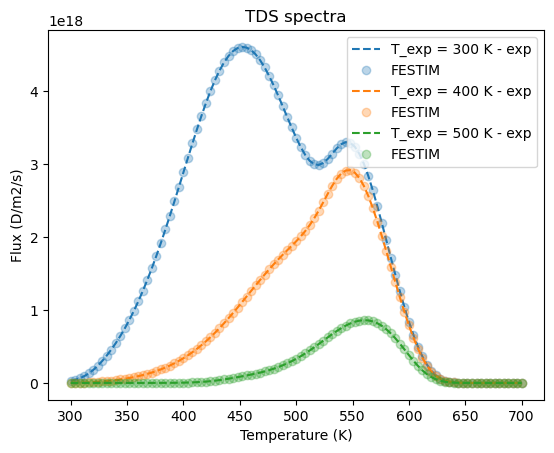

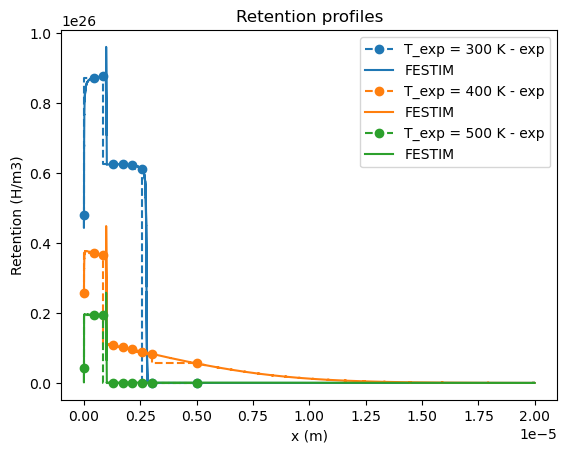

In [7]:
for T_exp in exposure_temps:

    derived_quantities = T_exp_to_derived_quantities[T_exp]

    plt.figure(1)
    (l,) = plot_experimental_tds(
        T_exp, label=f"T_exp = {T_exp} K - exp", linestyle="dashed"
    )
    plot_simulated_tds(
        derived_quantities=derived_quantities,
        color=l.get_color(),
        label=f"FESTIM",
        marker="o",
        alpha=0.3,
        linestyle="None",
    )

    plt.figure(2)
    filename = f"{T_exp}_K/retention.txt"
    (l,) = plot_nra_profile(
        T_exp, label=f"T_exp = {T_exp} K - exp", linestyle="dashed", marker="o"
    )
    plot_simulated_profile(filename, color=l.get_color(), label=f"FESTIM")

plt.figure(1)
plt.title("TDS spectra")
plt.xlabel("Temperature (K)")
plt.ylabel("Flux (D/m2/s)")
plt.legend()

plt.figure(2)
plt.title("Retention profiles")
plt.xlabel("x (m)")
plt.ylabel("Retention (H/m3)")
plt.legend()
plt.show()

## Generate dummy data for challenge

In [8]:
for T_exp in exposure_temps:
    data_retention = np.genfromtxt(
        f"{T_exp}_K/retention.txt", delimiter=",", skip_header=1
    )

    # sample a few points on the retention profile
    sample_points = np.linspace(0, 3e-6, num=8)
    sample_points = np.append(sample_points, 5e-6)
    sample_points_retention = np.interp(
        sample_points, data_retention[:, 0], data_retention[:, 1]
    )

    # dump sample_points and sample_points_retention to file with header
    np.savetxt(
        f"../challenge_B/{T_exp}_K/retention_profile.txt",
        np.column_stack((sample_points, sample_points_retention)),
        header="x (m), retention (H/m3)",
        comments="",
        delimiter=",",
    )

In [9]:
def save_tds(derived_quantities, filename):
    t = np.array(derived_quantities.t)
    indexes = np.where(t >= start_tds)[0]
    temp = np.array(derived_quantities.filter(fields="T").data)
    flux_left = np.array(derived_quantities.filter(fields="solute", surfaces=1).data)
    flux_right = np.array(derived_quantities.filter(fields="solute", surfaces=2).data)

    flux_total = -flux_left - flux_right

    temp = temp[indexes]
    flux_total = flux_total[indexes]
    t = t[indexes]

    np.savetxt(
        filename,
        np.column_stack((t, temp, flux_total)),
        header="t (s), T (K), flux (H/m2/s)",
        delimiter=",",
        comments="",
    )


for T_exp in exposure_temps:
    derived_quantities = T_exp_to_derived_quantities[T_exp]
    save_tds(derived_quantities, f"../challenge_B/{T_exp}_K/tds.txt")
